# 80_PoissonRegressionDemo

#### Tiny investigation into Possion regression upon count data

      
+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Generate Data](#Generate-Data)


+ [Poisson Regression](#Poisson-Regression)
    + [Create Design Matrices](#Create-Design-Matrices)
    + [Create Model](#Create-Model)
    + [Sample Model](#Sample-Model)
    + [View Diagnostics and Outputs](#View-Diagnostics-and-Outputs)


##### Package Requirements
```
$> less conda_env_pymc3_examples.yml

name: pymc3_examples
    channels:
      - defaults
    dependencies:
      - python=3.5
      - jupyter
      - numpy
      - scipy
      - matplotlib
      - pandas
      - seaborn
      - patsy  
      - pip
      - pip:
          - regex
          - Cython
          - pystan

$> conda env create --file conda_env_pymc3_examples.yml
$> source activate pymc3_examples
$> pip install --process-dependency-links git+https://github.com/pymc-devs/pymc3
```

# Setup

In [1]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')

import regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pt
from scipy import optimize

# pymc3 libraries
import pymc3 as pm
import theano as thno
import theano.tensor as T 
import pystan

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = 12, 4
np.random.seed(0)

##### What versions are we running?

In [3]:
print('Python: {}'.format(sys.version))
print('Recursion limit {}'.format(sys.getrecursionlimit()))
print('theano: {}'.format(thno.__version__))
print('PyMC3: {}'.format(pm.__version__))
print('PyStan: {}'.format(pystan.__version__))

Python: 3.5.1 |Continuum Analytics, Inc.| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Recursion limit 10000
theano: 0.8.1
PyMC3: 3.0
PyStan: 2.9.0.0


## Local Functions

In [4]:
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)     
    return ret_rvs

def plot_traces_pymc(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)
        
    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in 
                             pm.df_summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.df_summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022') 

## Generate Data

In [5]:
## sneezes get worse with booze whilst also no antihist
# note structured dataframe with nomeds as feature 
# so that alcohol == True & nomeds == True -> worst outcome

noalcohol_meds = 1    # no booze, took an antihist
alcohol_meds = 3      # booze, took an antihist
noalcohol_nomeds = 6  # no booze, no antihist
alcohol_nomeds = 36   # booze, no antihist

q = 1000
df = pd.DataFrame({
        'nsneeze': np.concatenate((np.random.poisson(noalcohol_meds, q),
                                   np.random.poisson(alcohol_meds, q),
                                   np.random.poisson(noalcohol_nomeds, q), 
                                   np.random.poisson(alcohol_nomeds, q))),
        'alcohol': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q))),
        'nomeds': np.concatenate((np.repeat(False, q),
                                      np.repeat(False, q),
                                      np.repeat(True, q),
                                      np.repeat(True, q)))})

In [6]:
df.groupby(['alcohol','nomeds']).mean().unstack()

nsneeze        
nomeds    False   True 
alcohol                
False     1.018   5.866
True      2.938  35.889

##### Describe Dataset

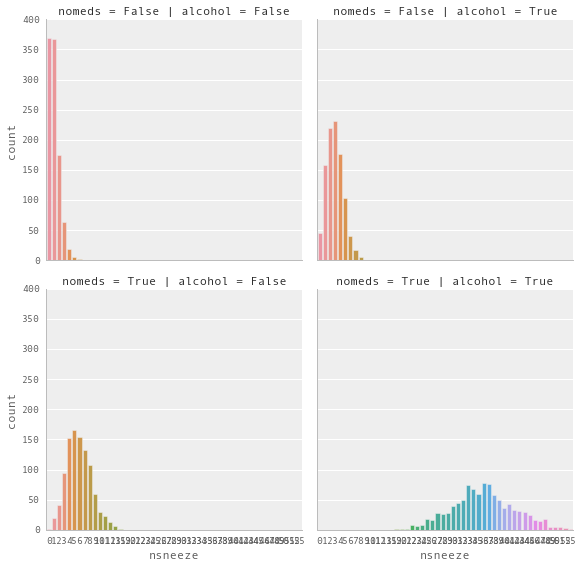

In [7]:
g = sns.factorplot(x='nsneeze', row='nomeds', col='alcohol', data=df,
               kind='count', size=4)

---

# Poisson Regression (PyMC3)

## Create Design Matrices

In [8]:
## fml = 'nsneeze ~ alcohol + antihist + alcohol:antihist'  # alt formualtion
fml = 'nsneeze ~ alcohol * nomeds'  # lazy formulation
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe', NA_action='raise')
mx_ex.head()

,Intercept,alcohol[T.True],nomeds[T.True],alcohol[T.True]:nomeds[T.True]
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [9]:
mx_ex.tail()

,Intercept,alcohol[T.True],nomeds[T.True],alcohol[T.True]:nomeds[T.True]
3995,1.0,1.0,1.0,1.0
3996,1.0,1.0,1.0,1.0
3997,1.0,1.0,1.0,1.0
3998,1.0,1.0,1.0,1.0
3999,1.0,1.0,1.0,1.0


## Create Model

In [11]:
with pm.Model() as mdl_fish:
    
    # define priors, weakly informative Normal
    b0 = pm.Normal('b0_intercept', mu=0, sd=10)
    b1 = pm.Normal('b1_alcohol[T.True]', mu=0, sd=10)
    b2 = pm.Normal('b2_nomeds[T.True]', mu=0, sd=10)
    b3 = pm.Normal('b3_alcohol[T.True]:nomeds[T.True]', mu=0, sd=10)
    
    # define linear model and exp link function
    mu = (b0 +
            b1 * mx_ex['alcohol[T.True]'] +
            b2 * mx_ex['nomeds[T.True]'] +
            b3 * mx_ex['alcohol[T.True]:nomeds[T.True]']) 

    ## Define Poisson likelihood 
    y = pm.Poisson('y', mu=np.exp(mu), observed=mx_en['nsneeze'].values)
    

##### Alternative automatic formulation using `pmyc.glm`

In [12]:
## Not used since it adds log link function, I thought link fn should be exp

# with pm.Model() as mdl_fish:
    
#     pm.glm.glm(fml, df, family=pm.glm.families.Poisson())

## Sample Model

In [13]:
with mdl_fish:
    
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)
    trc_fish = pm.sample(2000, start=start_MAP, njobs=2, step=pm.NUTS())

 [-----------------100%-----------------] 2000 of 2000 complete in 27.6 sec

## View Diagnostics and Outputs

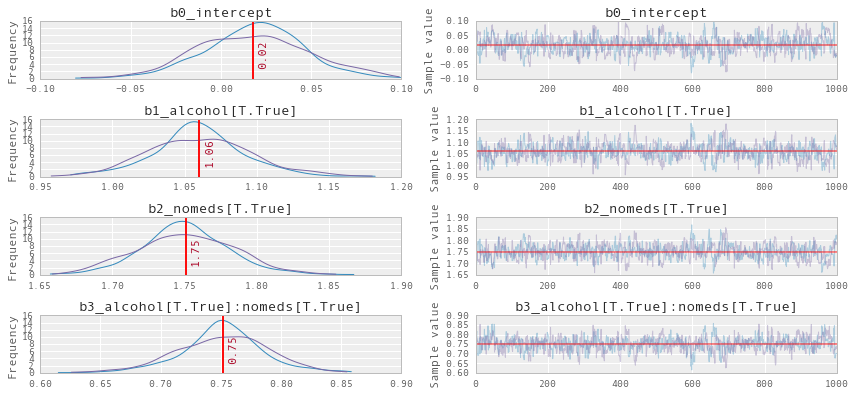

In [14]:
rvs_fish = [rv.name for rv in strip_derived_rvs(mdl_fish.unobserved_RVs)]
plot_traces_pymc(trc_fish[-1000:], varnames=rvs_fish)

##### Summary of coeffs

In [15]:
pm.df_summary(trc_fish[-1000:], varnames=rvs_fish)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
b0_intercept,0.017961,0.029258,0.001364,-0.035277,0.081063
b1_alcohol[T.True],1.060254,0.033685,0.001596,0.997563,1.135221
b2_nomeds[T.True],1.750669,0.031645,0.001452,1.684375,1.809248
b3_alcohol[T.True]:nomeds[T.True],0.751575,0.036019,0.001677,0.676727,0.822474


##### Trasform coeffs to see proportional increase on count

In [16]:
np.exp(pm.df_summary(trc_fish[-1000:], varnames=rvs_fish)[['mean','hpd_2.5','hpd_97.5']])

,mean,hpd_2.5,hpd_97.5
b0_intercept,1.018124,0.965338,1.084439
b1_alcohol[T.True],2.887104,2.711665,3.111860
b2_nomeds[T.True],5.758452,5.389080,6.105855
b3_alcohol[T.True]:nomeds[T.True],2.120337,1.967427,2.276124


### Observe 

+ Model converges quickly and traceplots looks pretty well mixed

+ The contributions from each feature as a multiplier of the baseline sneezecount appear to be as per the data generation:
    
    
    1. exp(b0_intercept): mu=0.98  cr=[0.92, 1.03]        
    
       Roughly linear baseline when no alcohol and meds
       which is as per the generated data: noalcohol_meds = 1


    2. exp(b1_alcohol): mu=3.08  cr=[2.88, 3.30]
    
       non-zero positive effect of adding alcohol, 
       a 3.08x multiplier of baseline sneeze count
       which is as per the generated data: noalcohol_meds * alcohol_meds = 1 * 3 = 3


    3. exp(b2_nomeds[T.True]): mu=6.07 cr=[5.68, 6.45]    
    
       larger, non-zero positive effect of adding nomeds 
       a 6.07x multiplier of baseline sneeze count
       which is as per the generated data: noalcohol_meds * noalcohol_nomeds = 1 * 6 = 6
    
    
    4. exp(b3_alcohol[T.True]:nomeds[T.True]): mu=1.97 cr=[1.83, 2.11]
    
       small, positive interaction effect of alcohol and meds
       a 1.97x multiplier of baseline sneeze count
       which is as per the generated data: 
           noalcohol_meds * alcohol_meds * 
           noalcohol_nomeds * alcohol_nomeds = 1 * 3 * 6 * 2 = 36
   


**NOTES:**

+ I think I have my logic correct
+ This is all wild hand-waving YMMV

---

# Additional Poisson Regression using PyStan for comparison

## Create Model

##### Define Input Dir

In [17]:
mdl_fish_stan_dict = {}
mdl_fish_stan_dict['N'] = mx_ex.shape[0]
mdl_fish_stan_dict['K'] = mx_ex.shape[1]
mdl_fish_stan_dict['X'] = mx_ex.values
mdl_fish_stan_dict['y'] = mx_en['nsneeze'].values.astype(np.int64)

##### Define Model

In [18]:
mdl_fish_stan_spec = """

    /* Spec for poisson regression model */

    data {                                 
        int<lower=0> N;                     // count of observations
        int<lower=0> K;                     // count of exog features
        matrix[N, K] X;                     // exog features
        int<lower=0> y[N];                  // endog feature (force int)
    }
    parameters {
        vector[K] beta;                     // exog coeffs
    }
    transformed parameters {}
    model {
        y ~ poisson(exp(X * beta));                 // poisson likelihood
    }
    generated quantities {}
    """

## Compile and sample

In [19]:
mdl_fish_stan_fit = pystan.stan(
        model_code  = mdl_fish_stan_spec,
        data        = mdl_fish_stan_dict,
        model_name  = 'mdl_fish_stan',
        iter        = 1000,
        warmup      = 750, 
        chains      = 4, 
        n_jobs      = 2, 
        verbose     = False)

## View results

##### View traceplots

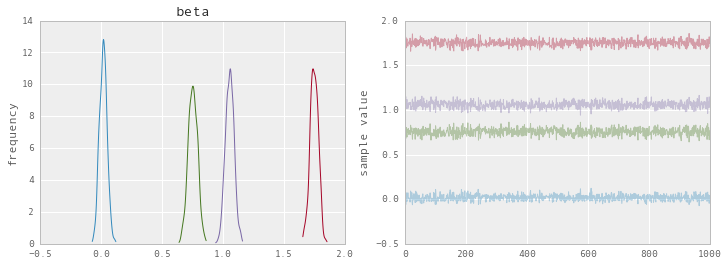

In [20]:
mdl_fish_stan_fit.plot(pars='beta')
plt.show()

##### View summary

In [21]:
print(mdl_fish_stan_fit)

Inference for Stan model: mdl_fish_stan_e46a2b15bcfd401f576c0e4868c3e0b6.
4 chains, each with iter=1000; warmup=750; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]   0.02  2.9e-3   0.03  -0.04-3.5e-3   0.02   0.04   0.08    116    1.0
beta[1]   1.06  3.6e-3   0.04   0.99   1.03   1.06   1.08   1.13     96    1.0
beta[2]   1.75  3.1e-3   0.03   1.68   1.73   1.75   1.78   1.81    115    1.0
beta[3]   0.75  3.8e-3   0.04   0.68   0.73   0.75   0.78   0.83     97    1.0
lp__     9.6e4    0.12   1.44  9.6e4  9.6e4  9.6e4  9.6e4  9.6e4    142   1.03

Samples were drawn using NUTS(diag_e) at Mon May  2 10:58:10 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


##### Extract results and transform

In [22]:
samples = mdl_fish_stan_fit.extract(permuted=True)  # return a dict of arrays
dftrc_fish_stan = pd.DataFrame(samples['beta'],columns=mx_ex.columns.tolist())

In [23]:
np.exp(dftrc_fish_stan.describe(percentiles=[.025,.975]))

,Intercept,alcohol[T.True],nomeds[T.True],alcohol[T.True]:nomeds[T.True]
count,inf,inf,inf,inf
mean,1.018398,2.877825,5.760774,2.125860
std,1.031475,1.035857,1.034184,1.038496
min,0.930029,2.562889,5.244244,1.896735
2.5%,0.959789,2.685474,5.375359,1.971770
50%,1.018576,2.880671,5.760544,2.126583
97.5%,1.081818,3.089054,6.123589,2.288306
max,1.129220,3.197135,6.397263,2.370601


**Observe:**

+ Cool, roughly the same results as above for PyMC3

---
**Applied AI Ltd &copy; 2016**  
<a href='http://www.applied.ai'>applied.ai</a>